In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

def import_sys():
    import sys
    sys.path.append('..')
import_sys()

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)  # pylint: disable=invalid-name


In [2]:
import pandas as pd
from tqdm import tqdm

from overrides import overrides

from errudite.io import DatasetReader
from errudite.utils import normalize_file_path, accuracy_score
from errudite.targets.instance import Instance
from errudite.targets.target import Target
from errudite.targets.label import Label, PredefinedLabel

In [3]:
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from typing import List, Dict
import sys
sys.path.append('..')
from errudite.predictors.predictor import Predictor
from errudite.targets.label import Label, PredefinedLabel

class Predictor_FLAN_T5(Predictor):
    def __init__(self, name: str, 
    model_path: str=None,
    model_online_path: str=None,
    description: str='',
    model_type: str=None) -> None:
        model = None
        Predictor.__init__(self, name, description, model, ['accuracy', 'accuracy_PE_Acceptable', 'accuracy_PE_Unacceptable', 'accuracy_PE_Insufficient', 'accuracy_PE_NotFound'
                                                            ,'accuracy_KE_Acceptable', 'accuracy_KE_Unacceptable', 'accuracy_KE_Insufficient', 'accuracy_KE_NotFound',
                                                           'accuracy_LCE_Acceptable', 'accuracy_LCE_Unacceptable', 'accuracy_LCE_Insufficient', 'accuracy_LCE_NotFound'])
        
    def predict_essay(self, essay : str) -> Dict[str,str]:
        # Load data into pandas DataFrame
        data_df = pd.read_excel("StudentEssays.xlsx")

        # Initialize T5 tokenizer and model
        tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
        model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

        # Move the model to the CUDA device if available
        if torch.cuda.is_available():
            model.to("cuda")

        # Define a list of concepts to predict
        concepts_to_predict = ["potential energy", "kinetic energy", "Law of Conservation of Energy"]

        # Define possible outcome labels
        outcome_labels = ["Acceptable", "Unacceptable", "Insufficient", "Not Found"]

        # Create a list to store predictions as dictionaries
        predictions_list = []

        text = essay  # Assuming the text content is in column 'Essay'

        # Initialize predictions dictionary for this row
        predictions = {}

        # Iterate through each concept to predict
        for concept in concepts_to_predict:
            # Define a template for classification
            template = f"According to the following essay, is the student's definition of {concept} Acceptable, Unacceptable, Insufficient, or Not Found? Only use one of these labels for outputs\n{text}"
            # Prepare the input by replacing placeholders
            formatted_input = template
            # Tokenize and classify the text
            input_ids = tokenizer(formatted_input, return_tensors="pt", padding=True, truncation=True).input_ids.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model.generate(input_ids, max_length=128)
            decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)  # Remove special tokens

            # Store the prediction in the dictionary
            predictions[concept] = next((label for label in outcome_labels if label.lower() in decoded_output.lower()), "Unknown")

            if predictions[concept] == "Unknown":
              print(len(decoded_output))
              with open('output.txt', 'w') as f:
                f.write(decoded_output)

        return predictions

INFO:pytorch_pretrained_bert.modeling:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
INFO:pytorch_transformers.modeling_bert:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
INFO:pytorch_transformers.modeling_xlnet:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
INFO:allennlp.common.registrable:instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
INFO:allennlp.common.registrable:instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
INFO:allennlp.common.registrable:instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
INFO:allennlp.common.registrable:instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>


In [4]:
@DatasetReader.register("STE")
class STEReader(DatasetReader):
    def __init__(self, cache_folder_path: str=None) -> None:
        super().__init__(cache_folder_path)
        # overwrite the primary evaluation method and metric name
        Label.set_task_evaluator(accuracy_score, 'accuracy')
        
    @overrides
    def _read(self, file_path: str, lazy: bool, sample_size: int):
        """
        Returns a list containing all the instances in the specified dataset.
 
        Parameters
        ----------
        file_path : str
            The path of the input data file.
        lazy : bool, optional
            If ``lazy==True``, only run the tokenization, does not compute the linguistic
            features like POS, NER. By default False
        sample_size : int, optional
            If sample size is set, only load this many of instances, by default None
        
        Returns
        -------
        List[Instance]
            The instance list.
        """
        instances = []
        essays = []
        logger.info("Reading instances from lines in file at: %s", file_path)
        df = pd.read_excel(normalize_file_path(file_path), sep='\t')
        for idx, row in tqdm(df.iterrows()):
            if lazy:
                essays.append(row['Essay'])
            else:
                instance = self._text_to_instance(f'q:{idx}', row)
                if instance is not None:
                    instances.append(instance)
                if sample_size and idx > sample_size:
                    break
        if lazy:
            return { "Essays": essays }
        else:
            return instances
    
    @overrides
    def _text_to_instance(self, id: str, row) -> Instance:
        # The function that transfers raw text to instance.
        essay = Target(qid=row['Essay_ID'], text=row['Essay'], vid=0, metas={'type': 'essays'})        # label
        groundtruth_PE = PredefinedLabel(
            model='groundtruth', 
            qid=row['Essay_ID'], 
            text=row['PE'], 
            vid=0, 
        )
        groundtruth_KE = PredefinedLabel(
            model='groundtruth', 
            qid=row['Essay_ID'], 
            text=row['KE'], 
            vid=0, 
        )
        groundtruth_LCE = PredefinedLabel(
            model='groundtruth', 
            qid=row['Essay_ID'], 
            text=row['LCE'], 
            vid=0, 
        )
        return self.create_instance(row['Essay_ID'], 
            essay=essay, 
            groundtruth_PE=groundtruth_PE,
            groundtruth_KE=groundtruth_KE,
            groundtruth_LCE=groundtruth_LCE)

In [5]:
from errudite.io import DatasetReader

cache_folder_path = "./ste_caches"
reader = DatasetReader.by_name("STE")(cache_folder_path=cache_folder_path)

INFO:errudite.utils.file_utils:Errudite cache folder selected: ./ste_caches


In [6]:
# read the raw data!
instances = reader.read(
    # The path of the input data file. We are using the first 100 rows from the SNLI dev set.
    file_path='StudentEssays.xlsx', 
    # If sample size is set, only load this many of instances, by default None.
    sample_size=76)

INFO:errudite.io.dataset_reader:Reading instances from lines in file at: StudentEssays.xlsx
INFO:__main__:Reading instances from lines in file at: StudentEssays.xlsx
76it [00:02, 31.54it/s]


In [7]:
from typing import List, Dict
import sys
sys.path.append('..')
from errudite.predictors.predictor import Predictor
from errudite.targets.label import Label, PredefinedLabel

In [8]:
@Predictor.register("STE_FLAN_T5")
class PredictorSTE(Predictor_FLAN_T5):
    def __init__(self, name: str, 
        model_path: str=None,
        model_online_path: str=None,
        description: str='') -> None:
        Predictor_FLAN_T5.__init__(self, name, model_path, model_online_path, description)
        import sys
        sys.path.append('..')
        from errudite.utils.evaluator import accuracy_score
        # Second, from the metrics above, pick one that's primary, and it will be used 
        # to compute `is_incorrect()` in any label target object: primary metric < 1.
        Label.set_task_evaluator(
            # the evaluation function that accepts pred and groundtruths, 
            # and return a dict of metrics: { metric_name: metric_score }. 
            # This is saved as Label.task_evaluation_func.
            task_evaluation_func=accuracy_score, 
            # The primary task metric name, ideally a key of task_evaluation_func ‘s return.
            task_primary_metric='accuracy')

    # the raw prediction function, returning the output of the model in a json format.
    def predict(self, essay: str) -> Dict[str, str]:
        predicted = self.predict_essay(essay)
        return predicted

    @classmethod
    # the class method that takes `Target` inputs, and output a `Label` object.
    def model_predict(cls, 
        predictor: Predictor, 
        essay: Target, 
        groundtruth_PE: Label, groundtruth_KE: Label, groundtruth_LCE: Label) -> 'Label':
        answer = None
        if not predictor:
            return answer
        predicted = predictor.predict(essay.get_text())
        if not predicted:
            return None
        answer_PE = PredefinedLabel(
            model=predictor.name, 
            qid=essay.qid,
            text=predicted['potential energy'], 
            vid=max([essay.vid]))
        answer_KE = PredefinedLabel(
            model=predictor.name, 
            qid=essay.qid,
            text=predicted['kinetic energy'], 
            vid=max([essay.vid]))
        answer_LCE = PredefinedLabel(
            model=predictor.name, 
            qid=essay.qid,
            text=predicted['Law of Conservation of Energy'], 
            vid=max([essay.vid]))
        answer_PE.compute_perform(groundtruths=groundtruth_PE)
        answer_KE.compute_perform(groundtruths=groundtruth_KE)
        answer_LCE.compute_perform(groundtruths=groundtruth_LCE)
        return answer_PE, answer_KE, answer_LCE



In [9]:
from errudite.predictors import Predictor
model_path = "FLAN_T5_Essay"
predictor = Predictor.by_name("STE_FLAN_T5")(
    name ='FLAN_T5', 
    description='Prediction created by FLAN_T5')

In [10]:
import traceback
from typing import Union, List
from spacy.tokens import Doc, Span, Token
def import_sys():
    import sys
    sys.path.append('..')
import_sys()
from errudite.utils.helpers import convert_doc
from errudite.utils.check import DSLValueError
import logging
logger = logging.getLogger(__name__)  # pylint: disable=invalid-name

In [11]:
from tqdm import tqdm 
logger.info("Running predictions....") 
for instance in tqdm(instances):
    prediction_PE, prediction_KE, prediction_LCE = Predictor.by_name("STE_FLAN_T5").model_predict(
        predictor, 
        essay = instance.essay,
        groundtruth_PE = instance.groundtruth_PE, groundtruth_KE = instance.groundtruth_KE, groundtruth_LCE = instance.groundtruth_LCE)
    # set the prediction
    instance.set_entries(prediction_PE = prediction_PE, prediction_KE = prediction_KE, prediction_LCE = prediction_LCE)

INFO:__main__:Running predictions....
100%|██████████| 76/76 [13:11<00:00, 11.62s/it]


In [12]:
# print(instances[2].get_entry('essay'), "\n")
# instances[2].show_instance()

In [16]:
# ---------
# Build the instance store hash
from errudite.targets.instance import Instance
instance_hash, instance_hash_rewritten, qid_hash = Instance.build_instance_hashes(instances)

In [17]:
predictor.evaluate_performance(instances)
print({"predictor": predictor.name, "perform": predictor.perform })

{'predictor': 'FLAN_T5', 'perform': {'accuracy': 0.039473684210526314, 'accuracy_PE_Acceptable': 0.0, 'accuracy_PE_Unacceptable': 'None', 'accuracy_PE_Insufficient': 0.7924528301886793, 'accuracy_PE_NotFound': 0.0, 'accuracy_KE_Acceptable': 'None', 'accuracy_KE_Unacceptable': 'None', 'accuracy_KE_Insufficient': 0.6341463414634146, 'accuracy_KE_NotFound': 0.11428571428571428, 'accuracy_LCE_Acceptable': 0.2857142857142857, 'accuracy_LCE_Unacceptable': 'None', 'accuracy_LCE_Insufficient': 0.0, 'accuracy_LCE_NotFound': 0.4857142857142857}}


## Group - Length of the Essay

In [18]:
from errudite.builts import Group
from errudite.builts import Attribute
group_length_10 = Group.create(
    # The name of the attribute
    name="length",
    # the description of the attribute
    description="length greater than 10",
    # All the previously created attributes and groups 
    # can be used and queried, as long as we serve the 
    # stored attributes and groups as part of the inputs.
    cmd="length(essay) > 10",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](>):[FuncOp(length):[ArgOp:essay]+[], 10.0]
INFO:errudite.builts.group:Created group: length


In [19]:
# some general stats on groups
Group.eval_stats(
    filtered_instances=group_length_10.get_instances(),
    # this will automatically call the default model we got
    model=None
)

{'counts': {'correct': 3, 'incorrect': 73},
 'stats': {'coverage': 1.0,
  'error_coverage': 1.0,
  'local_error_rate': 0.9605263157894737,
  'global_error_rate': 0.9605263157894737}}

In [20]:
from errudite.builts import Group
from errudite.builts import Attribute
group_length_200 = Group.create(
    # The name of the attribute
    name="length",
    # the description of the attribute
    description="length greater than 200",
    # All the previously created attributes and groups 
    # can be used and queried, as long as we serve the 
    # stored attributes and groups as part of the inputs.
    cmd="length(essay) > 200",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](>):[FuncOp(length):[ArgOp:essay]+[], 200.0]
INFO:errudite.builts.group:Created group: length


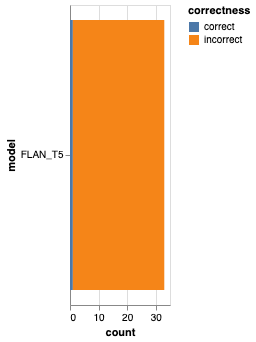

In [21]:
group_length_200.visualize_models(models=["FLAN_T5"])

In [22]:
# some general stats on groups
Group.eval_stats(
    filtered_instances=group_length_200.get_instances(),
    # this will automatically call the default model we got
    model=None
)

{'counts': {'correct': 1, 'incorrect': 32},
 'stats': {'coverage': 0.4342105263157895,
  'error_coverage': 0.4383561643835616,
  'local_error_rate': 0.9696969696969697,
  'global_error_rate': 0.42105263157894735}}

## Group - Quantitative Value

In [23]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import linguistic

@PrimFunc.register()
def contains_quantity(docs: Union['Target', Span]) -> bool:
    """
    Detect the presence of quantity entities in the essay.
    quantity entity: measurements or counts.
    """
    # Use the linguistic function to extract entity types
    #print(docs)
    entities = linguistic(docs, label='ent_type')
    # print(entities)
    # print(docs)
    contains='QUANTITY' in entities

    # Check if 'bottom' or 'top' is present in the extracted entity types
    #print(contains)
    return contains


In [24]:
from errudite.builts import Attribute, Group

# Create an attribute based on the location function
attr = Attribute.create(
    name="quantity_entities",
    description="Presence of quantity entities in the essay",
    cmd="contains_quantity(essay)"
)

# Create a group that checks for the presence of location entities
quantity_group = Group.create(
    name="quantity",
    description="quantity entity detected",
    cmd="attr:quantity_entities == TRUE",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)
quantity_group

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(contains_quantity):[ArgOp:essay]+[]
INFO:errudite.builts.attribute:Created attr: quantity_entities
INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](==):[[BuildBlockOp](attr):quantity_entities, True]
INFO:errudite.builts.group:Created group: quantity


<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class '

[Group](quantity): 
	CMD	: attr:quantity_entities == TRUE
	COUNT	: 49

In [ ]:
count_group_list = []

for key in quantity_group.get_instances():
    count_group_list.append(Instance.get(key))

predictor.evaluate_performance(count_group_list)
print({"predictor": predictor.name, "perform": predictor.perform })

In [66]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import linguistic

@PrimFunc.register()
def num_quantity(docs: Union['Target', Span]) -> bool:
    """
    Detect the number of quantity entities in the essay.
    quantity entity: measurements or counts.
    """
    # Use the linguistic function to extract entity types
    #print(docs)
    entities = linguistic(docs, label='ent_type')
    count = entities.count('QUANTITY')

    return count

from errudite.builts import Attribute, Group

# Create an attribute based on the location function
attr = Attribute.create(
    name="quantity_entities",
    description="number of quantity entities in the essay",
    cmd="num_quantity(essay)"
)

import numpy as np

data=list(attr.get_instances().values())
lower_quartile = np.percentile(data, 25)
upper_quartile = np.percentile(data, 75)
median=np.percentile(data, 50)


print("Lower Quartile :", lower_quartile)
print("median :",median)
print("Upper Quartile :", upper_quartile)



INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(num_quantity):[ArgOp:essay]+[]
INFO:errudite.builts.attribute:Created attr: quantity_entities


<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class '

In [78]:

# Create a group that checks for the presence of location entities
num_quantity_group = Group.create(
    name="num_quantity",
    description="quantity entity detected",
    cmd="attr:quantity_entities <= 0 ",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

num_quantity_group


INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](<=):[[BuildBlockOp](attr):quantity_entities, 0.0]
INFO:errudite.builts.group:Created group: num_quantity


[Group](num_quantity): 
	CMD	: attr:quantity_entities <= 0 
	COUNT	: 27

In [79]:
count_group_list = []

for key in num_quantity_group.get_instances():
    count_group_list.append(Instance.get(key))

predictor.evaluate_performance(count_group_list)
print({"predictor": predictor.name, "perform": predictor.perform })

{'predictor': 'FLAN_T5', 'perform': {'accuracy': 0.1111111111111111, 'accuracy_PE_Acceptable': 'None', 'accuracy_PE_Unacceptable': 'None', 'accuracy_PE_Insufficient': 0.88, 'accuracy_PE_NotFound': 0.0, 'accuracy_KE_Acceptable': 'None', 'accuracy_KE_Unacceptable': 'None', 'accuracy_KE_Insufficient': 0.5909090909090909, 'accuracy_KE_NotFound': 0.0, 'accuracy_LCE_Acceptable': 0.35714285714285715, 'accuracy_LCE_Unacceptable': 'None', 'accuracy_LCE_Insufficient': 0.0, 'accuracy_LCE_NotFound': 0.4}}


In [26]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import linguistic

@PrimFunc.register()
def contains_ordinal(docs: Union['Target', Span]) -> bool:
    """
    Detect the presence of ordinal entities in the essay.
    ordinal entity: measurements or counts.
    """
    # Use the linguistic function to extract entity types
    entities = linguistic(docs, label='ent_type')
    # print(entities)
    # print(docs)
    contains='ORDINAL' in entities
    # Check if 'bottom' or 'top' is present in the extracted entity types
    #print(contains)
    return contains


In [27]:
from errudite.builts import Attribute, Group

# Create an attribute based on the location function
attr = Attribute.create(
    name="ordinal_entities",
    description="Presence of ordinal entities in the essay",
    cmd="contains_ordinal(essay)"
)

# Create a group that checks for the presence of ordinal entities
ordinal_group = Group.create(
    name="ordinal",
    description="ordinal entity detected",
    cmd="attr:ordinal_entities == TRUE",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)
quantity_group

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(contains_ordinal):[ArgOp:essay]+[]
INFO:errudite.builts.attribute:Created attr: ordinal_entities
INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](==):[[BuildBlockOp](attr):ordinal_entities, True]
INFO:errudite.builts.group:Created group: ordinal


<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class '

[Group](quantity): 
	CMD	: attr:quantity_entities == TRUE
	COUNT	: 49

In [24]:
count_group_list = []

for key in ordinal_group.get_instances():
    count_group_list.append(Instance.get(key))

predictor.evaluate_performance(count_group_list)
print({"predictor": predictor.name, "perform": predictor.perform })

{'predictor': 'FLAN_T5', 'perform': {'accuracy': 0.0, 'accuracy_PE_Acceptable': 'None', 'accuracy_PE_Unacceptable': 'None', 'accuracy_PE_Insufficient': 0.7142857142857143, 'accuracy_PE_NotFound': 0.0, 'accuracy_KE_Acceptable': 'None', 'accuracy_KE_Unacceptable': 'None', 'accuracy_KE_Insufficient': 0.42857142857142855, 'accuracy_KE_NotFound': 0.14285714285714285, 'accuracy_LCE_Acceptable': 0.4, 'accuracy_LCE_Unacceptable': 'None', 'accuracy_LCE_Insufficient': 0.0, 'accuracy_LCE_NotFound': 0.2857142857142857}}


## Group - Number of Adjectives

In [25]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import STRING
import spacy
nlp = spacy.load("en_core_web_sm")


@PrimFunc.register()
def num_adjectives(target: 'Target') -> int:
    """
    Count the number of adjectives in a given target.
    """
    try:
        # Access the tokens associated with the Target
        #print(STRING(target))
        #tokens = STRING(target).tokens
        doc = nlp(STRING(target))
        adjectives = [token for token in doc if token.pos_ == "ADJ"]
        return len(adjectives)
    except Exception as e:
        ex = Exception(f"Unknown exception from [num_adjectives]: {e}")
        raise ex




In [26]:
from errudite.builts import Attribute, Group

# Assuming you have already defined the PrimFunc num_adjectives

# Create an attribute that counts the adjectives among essay targets
attr = Attribute.create(
    name="num_adjectives_in_essay",
    description="Number of adjectives among essay targets",
    cmd="num_adjectives(essay)"
)


# Create a group to check if there are more than 5 adjectives in the essay
adj_count_group = Group.create(
    name="adjective_count_group",
    description="Group for counting adjectives in the essay",
    cmd="attr:num_adjectives_in_essay > 10",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

# You can now use the 'group' to check if there are more than 5 adjectives in your essay targets.
adj_count_group

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(num_adjectives):[ArgOp:essay]+[]
INFO:errudite.builts.attribute:Created attr: num_adjectives_in_essay
INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](>):[[BuildBlockOp](attr):num_adjectives_in_essay, 10.0]
INFO:errudite.builts.group:Created group: adjective_count_group


[Group](adjective_count_group): 
	CMD	: attr:num_adjectives_in_essay > 10
	COUNT	: 61

In [27]:
count_group_list = []
for key in adj_count_group.get_instances():
    count_group_list.append(Instance.get(key))

predictor.evaluate_performance(count_group_list)
print({"predictor": predictor.name, "perform": predictor.perform })

{'predictor': 'FLAN_T5', 'perform': {'accuracy': 0.03278688524590164, 'accuracy_PE_Acceptable': 0.0, 'accuracy_PE_Unacceptable': 'None', 'accuracy_PE_Insufficient': 0.8205128205128205, 'accuracy_PE_NotFound': 0.0, 'accuracy_KE_Acceptable': 'None', 'accuracy_KE_Unacceptable': 'None', 'accuracy_KE_Insufficient': 0.7096774193548387, 'accuracy_KE_NotFound': 0.13333333333333333, 'accuracy_LCE_Acceptable': 0.2682926829268293, 'accuracy_LCE_Unacceptable': 'None', 'accuracy_LCE_Insufficient': 0.0, 'accuracy_LCE_NotFound': 0.5}}


## Group - Number of Verbs

In [28]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import STRING
import spacy
nlp = spacy.load("en_core_web_sm")


@PrimFunc.register()
def num_verbs(target: 'Target') -> int:
    """
    Count the number of verbs in a given target.
    """
    try:
        # Access the tokens associated with the Target
        #print(STRING(target))
        #tokens = STRING(target).tokens
        doc = nlp(STRING(target))
        adjectives = [token for token in doc if token.pos_ == "VERB"]
        return len(adjectives)
    except Exception as e:
        ex = Exception(f"Unknown exception from [num_adjectives]: {e}")
        raise ex




In [29]:
from errudite.builts import Attribute, Group

# Assuming you have already defined the PrimFunc num_adjectives

# Create an attribute that counts the adjectives among essay targets
attr = Attribute.create(
    name="num_verbs_in_essay",
    description="Number of verbs among essay targets",
    cmd="num_verbs(essay)"
)


# Create a group to check if there are more than 20 verbs in the essay
verb_count_group = Group.create(
    name="verb_count_group",
    description="Group for counting verbs in the essay",
    cmd="attr:num_verbs_in_essay > 40",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

# You can now use the 'group' to check if there are more than 5 adjectives in your essay targets.
verb_count_group

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(num_verbs):[ArgOp:essay]+[]
INFO:errudite.builts.attribute:Created attr: num_verbs_in_essay
INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](>):[[BuildBlockOp](attr):num_verbs_in_essay, 40.0]
INFO:errudite.builts.group:Created group: verb_count_group


[Group](verb_count_group): 
	CMD	: attr:num_verbs_in_essay > 40
	COUNT	: 20

In [30]:
count_group_list = []
for key in verb_count_group.get_instances():
    count_group_list.append(Instance.get(key))

predictor.evaluate_performance(count_group_list)
print({"predictor": predictor.name, "perform": predictor.perform })

{'predictor': 'FLAN_T5', 'perform': {'accuracy': 0.05, 'accuracy_PE_Acceptable': 'None', 'accuracy_PE_Unacceptable': 'None', 'accuracy_PE_Insufficient': 0.7142857142857143, 'accuracy_PE_NotFound': 0.0, 'accuracy_KE_Acceptable': 'None', 'accuracy_KE_Unacceptable': 'None', 'accuracy_KE_Insufficient': 0.7272727272727273, 'accuracy_KE_NotFound': 0.2222222222222222, 'accuracy_LCE_Acceptable': 0.2857142857142857, 'accuracy_LCE_Unacceptable': 'None', 'accuracy_LCE_Insufficient': 0.0, 'accuracy_LCE_NotFound': 0.4444444444444444}}


In [31]:
# # some general stats on groups
# Group.eval_stats(
#     filtered_instances=adj_count_group.get_instances(),
#     # this will automatically call the default model we got
#     model=None
# )

## Group - Number of Nouns

In [32]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import STRING
import spacy
nlp = spacy.load("en_core_web_sm")


@PrimFunc.register()
def num_verbs(target: 'Target') -> int:
    """
    Count the number of verbs in a given target.
    """
    try:
        # Access the tokens associated with the Target
        #print(STRING(target))
        #tokens = STRING(target).tokens
        doc = nlp(STRING(target))
        adjectives = [token for token in doc if token.pos_ == "NOUN"]
        return len(adjectives)
    except Exception as e:
        ex = Exception(f"Unknown exception from [num_adjectives]: {e}")
        raise ex




In [115]:
from errudite.builts import Attribute, Group

# Assuming you have already defined the PrimFunc num_adjectives

# Create an attribute that counts the adjectives among essay targets
attr = Attribute.create(
    name="num_verbs_in_essay",
    description="Number of verbs among essay targets",
    cmd="num_verbs(essay)"
)


# Create a group to check if there are more than 20 verbs in the essay
verb_count_group = Group.create(
    name="verb_count_group",
    description="Group for counting verbs in the essay",
    cmd="attr:num_verbs_in_essay > 50",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

# You can now use the 'group' to check if there are more than 5 adjectives in your essay targets.
verb_count_group

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(num_verbs):[ArgOp:essay]+[]
INFO:errudite.builts.attribute:Created attr: num_verbs_in_essay
INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](>):[[BuildBlockOp](attr):num_verbs_in_essay, 50.0]
INFO:errudite.builts.group:Created group: verb_count_group


[Group](verb_count_group): 
	CMD	: attr:num_verbs_in_essay > 50
	COUNT	: 22

In [116]:
count_group_list = []
for key in verb_count_group.get_instances():
    count_group_list.append(Instance.get(key))

predictor.evaluate_performance(count_group_list)
print({"predictor": predictor.name, "perform": predictor.perform })

{'predictor': 'FLAN_T5', 'perform': {'accuracy': 0.045454545454545456, 'accuracy_PE_Acceptable': 0.0, 'accuracy_PE_Unacceptable': 'None', 'accuracy_PE_Insufficient': 0.6363636363636364, 'accuracy_PE_NotFound': 0.0, 'accuracy_KE_Acceptable': 'None', 'accuracy_KE_Unacceptable': 'None', 'accuracy_KE_Insufficient': 0.6666666666666666, 'accuracy_KE_NotFound': 0.15384615384615385, 'accuracy_LCE_Acceptable': 0.25, 'accuracy_LCE_Unacceptable': 'None', 'accuracy_LCE_Insufficient': 0.0, 'accuracy_LCE_NotFound': 0.6153846153846154}}


## Group - Contains Location Entity

In [155]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import STRING
import spacy
nlp = spacy.load("en_core_web_sm")


@PrimFunc.register()
def contains_loc(target: 'Target') -> int:
    """
    Detect the presence of location entities ('bottom' or 'top') in the essay.
    """
    try:
        # Access the tokens associated with the Target
        target_str=STRING(target)
        #tokens = STRING(target).tokens
        if "bottom" in target_str or "top" in target_str:
            return True
    except Exception as e:
        ex = Exception(f"Unknown exception from [num_adjectives]: {e}")
        raise ex



In [156]:
from errudite.builts import Attribute, Group

# Assuming you have already defined the PrimFunc num_adjectives

# Create an attribute that counts the adjectives among essay targets
attr = Attribute.create(
    name="contains_loc_in_essay",
    description="Number of locations among essay targets",
    cmd="contains_loc(essay)"
)


# Create a group to check if there are more than 5 adjectives in the essay
contains_loc_group = Group.create(
    name="adjective_count_group",
    description="Group for counting locations in the essay",
    cmd="attr:contains_loc_in_essay==TRUE ",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

# You can now use the 'group' to check if there are more than 5 adjectives in your essay targets.
contains_loc_group

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(contains_loc):[ArgOp:essay]+[]
INFO:errudite.builts.attribute:Created attr: contains_loc_in_essay
INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](==):[[BuildBlockOp](attr):contains_loc_in_essay, True]
INFO:errudite.builts.group:Created group: adjective_count_group


[Group](adjective_count_group): 
	CMD	: attr:contains_loc_in_essay==TRUE 
	COUNT	: 57

In [157]:
# some general stats on groups
Group.eval_stats(
    filtered_instances=contains_loc_group.get_instances(),
    # this will automatically call the default model we got
    model=None
)

{'counts': {'correct': 3, 'incorrect': 54},
 'stats': {'coverage': 0.75,
  'error_coverage': 0.7397260273972602,
  'local_error_rate': 0.9473684210526315,
  'global_error_rate': 0.7105263157894737}}

In [ ]:
contains_loc_group.visualize_models(models=["FLAN_T5"])

In [158]:
count_group_list = []
for key in contains_loc_group.get_instances():
    count_group_list.append(Instance.get(key))

predictor.evaluate_performance(count_group_list)
print({"predictor": predictor.name, "perform": predictor.perform })

{'predictor': 'FLAN_T5', 'perform': {'accuracy': 0.05263157894736842, 'accuracy_PE_Acceptable': 0.0, 'accuracy_PE_Unacceptable': 'None', 'accuracy_PE_Insufficient': 0.825, 'accuracy_PE_NotFound': 0.0, 'accuracy_KE_Acceptable': 'None', 'accuracy_KE_Unacceptable': 'None', 'accuracy_KE_Insufficient': 0.7, 'accuracy_KE_NotFound': 0.07407407407407407, 'accuracy_LCE_Acceptable': 0.2631578947368421, 'accuracy_LCE_Unacceptable': 'None', 'accuracy_LCE_Insufficient': 0.0, 'accuracy_LCE_NotFound': 0.5185185185185185}}


In [119]:
# from errudite.build_blocks import PrimFunc
# from errudite.build_blocks.prim_funcs.linguistic import STRING
# import spacy
# nlp = spacy.load("en_core_web_sm")


# @PrimFunc.register()
# def contains_loc(target: 'Target') -> int:
#     """
#     Detect the presence of location entities ('bottom' or 'top') in the essay.
#     """
#     try:
#         # Access the tokens associated with the Target
#         answer_type(target)
#         #target_str=STRING(target)
#         #tokens = STRING(target).tokens
#         #if "bottom" in target_str or "top" in target_str:
#          #   return True
#     except Exception as e:
#         ex = Exception(f"Unknown exception from [num_adjectives]: {e}")
#         raise ex



In [120]:
# from errudite.builts import Attribute, Group

# # Assuming you have already defined the PrimFunc num_adjectives

# # Create an attribute that counts the adjectives among essay targets
# attr = Attribute.create(
#     name="contains_loc_in_essay",
#     description="Number of adjectives among essay targets",
#     cmd="contains_loc(essay)"
# )


# # Create a group to check if there are more than 5 adjectives in the essay
# contains_loc_group = Group.create(
#     name="adjective_count_group",
#     description="Group for counting adjectives in the essay",
#     cmd="attr:contains_loc_in_essay==TRUE ",
#     attr_hash=Attribute.store_hash(),
#     group_hash=Group.store_hash()
# )

# # You can now use the 'group' to check if there are more than 5 adjectives in your essay targets.
# contains_loc_group

In [121]:
count_group_list = []
for key in verb_count_group.get_instances():
    count_group_list.append(Instance.get(key))

predictor.evaluate_performance(count_group_list)
print({"predictor": predictor.name, "perform": predictor.perform })

In [134]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import STRING
import spacy
nlp = spacy.load("en_core_web_sm")


@PrimFunc.register()
def num_assertions(target: 'Target') -> int:
    """
    Count the number of verbs in a given target.
    """
    try:
        # Access the tokens associated with the Target
        #print(STRING(target))
        #tokens = STRING(target).tokens
        doc = nlp(STRING(target))
        # Filter statements starting with "I believe" or "I think"
        filtered_statements = [sent.text for sent in doc.sents if sent.text.lower().startswith("i believe") or sent.text.lower().startswith("i think")]
        #print(filtered_statements)
        return filtered_statements
    except Exception as e:
        ex = Exception(f"Unknown exception from [  ]: {e}")
        raise ex
        
        
        






In [135]:
from errudite.builts import Attribute, Group

# Assuming you have already defined the PrimFunc num_adjectives

# Create an attribute that counts the adjectives among essay targets
attr = Attribute.create(
    name="contains_loc_in_essay",
    description="Number of adjectives among essay targets",
    cmd="num_assertions(essay)"
)


# Create a group to check if there are more than 5 adjectives in the essay
contains_loc_group = Group.create(
    name="adjective_count_group",
    description="Group for checking assertions in the essay",
    cmd="attr:contains_loc_in_essay==TRUE ",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

# You can now use the 'group' to check if there are more than 5 adjectives in your essay targets.
contains_loc_group

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(num_assertions):[ArgOp:essay]+[]
INFO:errudite.builts.attribute:Created attr: contains_loc_in_essay
INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](==):[[BuildBlockOp](attr):contains_loc_in_essay, True]
INFO:errudite.builts.group:Created group: adjective_count_group


[Group](adjective_count_group): 
	CMD	: attr:contains_loc_in_essay==TRUE 
	COUNT	: 0

In [131]:
count_group_list = []
for key in verb_count_group.get_instances():
    count_group_list.append(Instance.get(key))

predictor.evaluate_performance(count_group_list)
print({"predictor": predictor.name, "perform": predictor.perform })

{'predictor': 'FLAN_T5', 'perform': {'accuracy': 0.045454545454545456, 'accuracy_PE_Acceptable': 0.0, 'accuracy_PE_Unacceptable': 'None', 'accuracy_PE_Insufficient': 0.6363636363636364, 'accuracy_PE_NotFound': 0.0, 'accuracy_KE_Acceptable': 'None', 'accuracy_KE_Unacceptable': 'None', 'accuracy_KE_Insufficient': 0.6666666666666666, 'accuracy_KE_NotFound': 0.15384615384615385, 'accuracy_LCE_Acceptable': 0.25, 'accuracy_LCE_Unacceptable': 'None', 'accuracy_LCE_Insufficient': 0.0, 'accuracy_LCE_NotFound': 0.6153846153846154}}


In [40]:
import numpy as np

data = [4, 1, 1, 3, 3, 1, 4, 1, 4, 5, 0, 2, 1, 3, 0, 1, 0, 3, 4, 1, 0, 3, 0, 5, 0, 2, 3, 0, 0, 1, 4, 2, 0, 0, 8, 1, 1, 2, 0, 3, 0, 1, 4, 0, 0, 0, 1, 0, 1, 2, 2, 3, 2, 6, 2, 2, 1, 2, 2, 1, 3, 8, 2, 2, 11, 6, 3, 3, 2, 10, 2, 1, 1, 3, 2, 0]

# Calculate the lower quartile (Q1)
lower_quartile = np.percentile(data, 25)
upper_quartile = np.percentile(data, 75)
median=np.percentile(data, 50)


print("Lower Quartile :", lower_quartile)
print("median :",median)

print("Upper Quartile :", upper_quartile)

Lower Quartile : 1.0
median : 2.0
Upper Quartile : 3.0


In [41]:
import spacy

# Load the SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Example text
text = "I don't believe that understanding potential energy is not crucial. However, I think kinetic energy is equally important."

# Process the text using SpaCy
doc = nlp(text)

# Identify negations
negations = [token.text for token in doc if token.dep_ == "neg"]

# Count the number of negations
num_negations = len(negations)

# Print the results
print("Negations:", negations)
print("Number of negations:", num_negations)


Negations: ["n't", 'not']
Number of negations: 2


In [48]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import STRING
import spacy
nlp = spacy.load("en_core_web_sm")


@PrimFunc.register()
def num_negations(target: 'Target') -> int:
    """
    Count the number of verbs in a given target.
    """
    try:
        # Access the tokens associated with the Target
        #print(STRING(target))
        #tokens = STRING(target).tokens
        doc = nlp(STRING(target))
        # Identify negations
        negations = [token.text for token in doc if token.dep_ == "neg"]
        # Count the number of negations
        num_negations = len(negations)
        return num_negations
    except Exception as e:
        ex = Exception(f"Unknown exception from [  ]: {e}")
        raise ex
        
        
    

In [51]:
from errudite.builts import Attribute, Group

# Assuming you have already defined the PrimFunc num_adjectives

# Create an attribute that counts the adjectives among essay targets
attr = Attribute.create(
    name="contains_negation_in_essay",
    description="Number of nagations among essay targets",
    cmd="num_negations(essay)"
)


# Create a group to check if there are more than 5 adjectives in the essay
contains_negation_group = Group.create(
    name="contains_negation_group",
    description="Group for checking negations in the essay",
    cmd="attr:contains_negation_in_essay  >= 3 ",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

# You can now use the 'group' to check if there are more than 5 adjectives in your essay targets.
contains_negation_group

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(num_negations):[ArgOp:essay]+[]
INFO:errudite.builts.attribute:Created attr: contains_negation_in_essay
INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](>=):[[BuildBlockOp](attr):contains_negation_in_essay, 3.0]
INFO:errudite.builts.group:Created group: contains_negation_group


[Group](contains_negation_group): 
	CMD	: attr:contains_negation_in_essay  >= 3 
	COUNT	: 26

In [52]:
count_group_list = []
for key in contains_negation_group.get_instances():
    count_group_list.append(Instance.get(key))

predictor.evaluate_performance(count_group_list)
print({"predictor": predictor.name, "perform": predictor.perform })

{'predictor': 'FLAN_T5', 'perform': {'accuracy': 0.038461538461538464, 'accuracy_PE_Acceptable': 'None', 'accuracy_PE_Unacceptable': 'None', 'accuracy_PE_Insufficient': 0.7222222222222222, 'accuracy_PE_NotFound': 0.0, 'accuracy_KE_Acceptable': 'None', 'accuracy_KE_Unacceptable': 'None', 'accuracy_KE_Insufficient': 0.5, 'accuracy_KE_NotFound': 0.2, 'accuracy_LCE_Acceptable': 0.4117647058823529, 'accuracy_LCE_Unacceptable': 'None', 'accuracy_LCE_Insufficient': 0.0, 'accuracy_LCE_NotFound': 0.4}}
